<a href="https://colab.research.google.com/github/jenniferhiga/HCI_AI_RoboticSurgery/blob/main/Grounded_SAM_Tool_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Requirements

In [ ]:
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything

Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1619, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 1619 (delta 240), reused 226 (delta 218), pack-reused 1326
Receiving objects: 100% (1619/1619), 124.72 MiB | 40.14 MiB/s, done.
Resolving deltas: 100% (745/745), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# /////////////// Import libraries and packages ///////////////
import PIL
from PIL import Image
import requests
import torch
from io import BytesIO
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from skimage import exposure
from skimage.filters import gaussian
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
from torchvision.transforms import v2 as v2

Image downloaded from url: https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg and saved to: inpaint_demo.jpg.


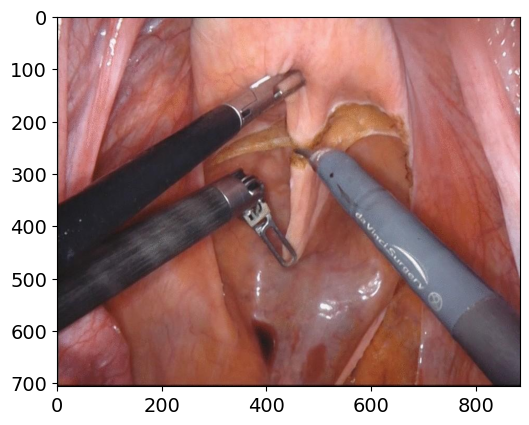

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

local_image_path = "inpaint_demo.jpg"
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
plt.imshow(image_source)

In [ ]:
class perturbation_class:

    def gamma_correction(img):
        seq = []
        gammas = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]#np.arange(1,0.1,-.03)
        img = Image.fromarray(img)
        for i in range(len(gammas)):
            z = TF.adjust_gamma(img, gammas[i], gain=1)
            seq.append(z)
        return seq

    def contrast(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_contrast(img, factors[i])
            seq.append(z)
        return seq

    def brightness(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_brightness(img, factors[i])
            seq.append(z)
        return seq

    def sharpness(img):
        seq = []
        #factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        factors = [ -6, -4, -2, 1, 2, 4, 6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_sharpness(img, factors[i])
            seq.append(z)
        return seq

    def gaussian_blur(img):
        seq = []
        #Question for Mobarak, how did you determine these kernel sizes?
        ksize = [1, 3, 5, 7, 9, 11, 51]
        img = Image.fromarray(img)
        for i in range(len(ksize)):
            z = TF.gaussian_blur(img, kernel_size=ksize[i])
            seq.append(np.array(z))
        return seq


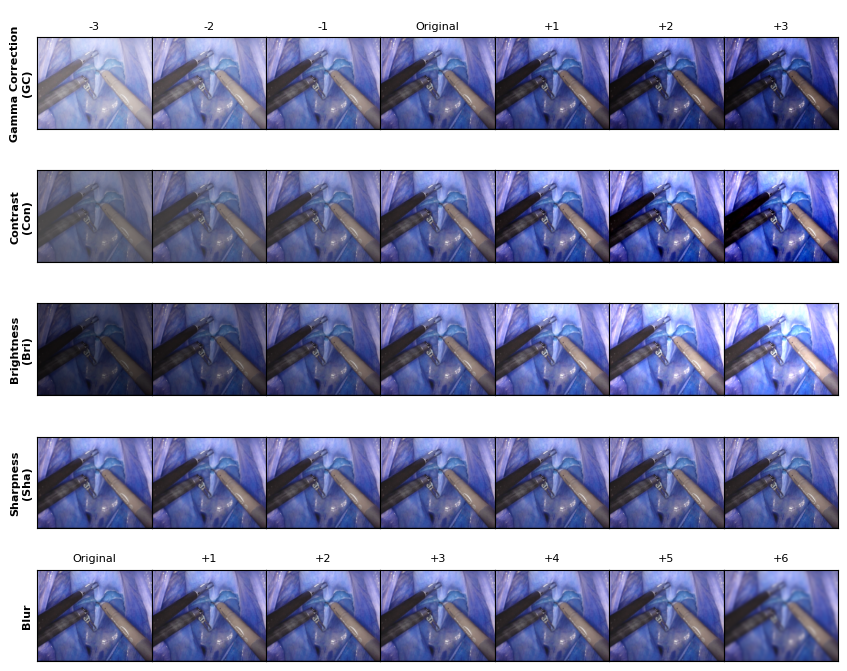

In [ ]:
img_dir = 'inpaint_demo.jpg'
original = cv2.imread(img_dir)
plt.rcParams.update({'font.size': 14})
ptech_list = ['Original', '+1', '+2', '+3', '+4', '+5', '+6']
f_size = 8
perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur']
filter_name = ['Gamma Correction\n(GC)', 'Contrast\n(Con)', 'Brightness\n(Bri)', 'Sharpness\n(Sha)','Blur']
seq_all = [0, 1, 2, 3, 4, 5, 6]
levels = ['-3','-2','-1','Original','+1','+2','+3']
levels_real = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
fig_per_row = len(seq_all)
fig, ax = plt.subplots(len(perturbation_all), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
for p_idx, per in enumerate(perturbation_all):
    class_method = getattr(perturbation_class, per)
    seq = class_method(original)
    for idx, seq_idx in enumerate(seq_all):
        if p_idx == 4:
            ax[p_idx, idx].set_title('{}'.format(ptech_list[idx]), fontsize=f_size)
        if idx == 3:
            #seq[seq_idx] = cv2.cvtColor(seq[seq_idx], cv2.COLOR_BGR2RGB)
            ax[p_idx, idx].imshow(seq[seq_idx])#, cmap='gray')
        else:
            seq[seq_idx] = cv2.cvtColor(seq[seq_idx], cv2.COLOR_BGR2RGB)
            ax[p_idx, idx].imshow(seq[seq_idx])#, cmap='gray')

        if p_idx == 0:
            if levels[idx] == 'Original':
                ax[p_idx, idx].set_title('\n{}'.format(levels[idx]), fontsize=f_size)
            else:
                ax[p_idx, idx].set_title('{}'.format(levels[idx], levels_real[idx]), fontsize=f_size)
        if idx == 0:
            ax[p_idx, idx].set_ylabel(filter_name[p_idx], fontsize=f_size, fontweight="bold")

        ax[p_idx, idx].xaxis.set_major_locator(plt.NullLocator())
        ax[p_idx, idx].yaxis.set_major_locator(plt.NullLocator())


fig.show()
# plt.savefig('perturbation_effect_v2.pdf',dpi=100)

In [ ]:
img_dir = 'inpaint_demo.jpg'
original = cv2.imread(img_dir)
plt.rcParams.update({'font.size': 14})
ptech_list = ['Original', '+1', '+2', '+3', '+4', '+5', '+6']
f_size = 8
perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur']
filter_name = ['Gamma Correction\n(GC)', 'Contrast\n(Con)', 'Brightness\n(Bri)', 'Sharpness\n(Sha)','Blur']
seq_all = [0, 1, 2, 3, 4, 5, 6]
levels = ['-3','-2','-1','Original','+1','+2','+3']
levels_real = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
fig_per_row = len(seq_all)
fig, ax = plt.subplots(len(perturbation_all), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
for p_idx, per in enumerate(perturbation_all):
    class_method = getattr(perturbation_class, per)
    seq = class_method(original)
    for idx, seq_idx in enumerate(seq_all):
      img = seq[seq_idx]
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plt.savefig('perturbation_effect_v2.pdf',dpi=100)

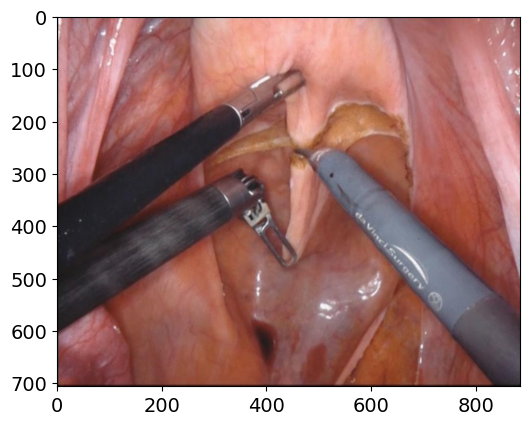

In [ ]:
#seq[0] = cv2.cvtColor(seq[0], cv2.COLOR_BGR2RGB)
#plt.imshow(seq[0])

seq[1] = cv2.cvtColor(seq[1], cv2.COLOR_BGR2RGB)
plt.imshow(seq[1])

#seq[2] = cv2.cvtColor(seq[2], cv2.COLOR_BGR2RGB)
#plt.imshow(seq[2])

#seq[3] = cv2.cvtColor(seq[3], cv2.COLOR_BGR2RGB)
#plt.imshow(seq[3])

Cropping

In [ ]:
class crop_class:
  def center_crop(img):
    seq = []
    sizes = [50, 150, 250, 350, 450, 550, 700]
    for i in range(len(sizes)):
      z = TF.center_crop(original, sizes[i])
      seq.append(z)
    return seq

  def center_crop_tiny(img):
    seq = []
    sizes = [30, 40, 50, 60, 70, 80, 90]
    for i in range(len(sizes)):
      z = TF.center_crop(original, sizes[i])
      seq.append(z)
    return seq

  def center_crop_big(img):
    seq = []
    sizes = [200, 300, 500, 800, 1000, 1200, 1400]
    for i in range(len(sizes)):
      z = TF.center_crop(original, sizes[i])
      seq.append(z)
    return seq

In [ ]:

super_cropped=TF.resized_crop(Image.fromarray(original), 80, 500, 80, 80, 500)
super_cropped.save("NewImage.png")

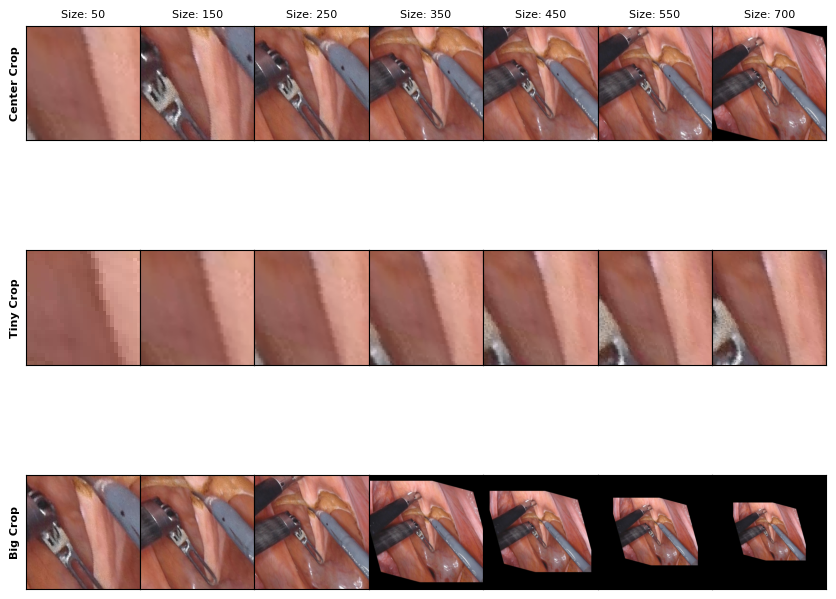

In [ ]:
img_dir = 'inpaint_demo.jpg'
original = Image.fromarray(image_source)
crop_type = ['Center Crop', 'Tiny Crop', 'Big Crop']
seq_all = [0, 1, 2, 3, 4, 5, 6]
sizes = [50, 150, 250, 350, 450, 550, 700]
perturbation_crops = ['center_crop','center_crop_tiny', 'center_crop_big']
if os.path.isdir('cropped_imgs'):
    print(f"{'cropped_imgs'} exists.")
else:
  os.mkdir('cropped_imgs')
fig_per_row = len(seq_all)
fig, ax = plt.subplots(len(perturbation_crops), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
for p_idx, per in enumerate(perturbation_crops):
    class_method = getattr(crop_class, per)
    seq = class_method(original)
    for idx, seq_idx in enumerate(seq_all):
      seq[seq_idx].save('cropped_imgs/crop{}.png'.format(seq_idx))
      ax[p_idx, idx].imshow(seq[seq_idx])
      if p_idx == 0:
        ax[p_idx, idx].set_title('Size: ' + '{}'.format(sizes[idx]), fontsize=f_size)
      if idx == 0:
        ax[p_idx, idx].set_ylabel(crop_type[p_idx], fontsize=f_size, fontweight="bold")

      ax[p_idx, idx].xaxis.set_major_locator(plt.NullLocator())
      ax[p_idx, idx].yaxis.set_major_locator(plt.NullLocator())
plt.savefig('Crop_Effects.pdf',dpi=100)

This code block below just uses the five crop, but with seven different types to iterate in a grid, did this one separately.

fivecrop_imgs exists.


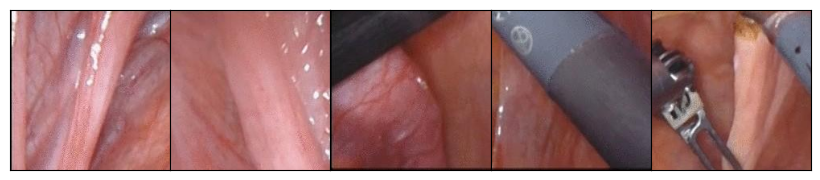

In [ ]:
img_dir = 'inpaint_demo.jpg'
original = Image.fromarray(image_source)
if os.path.isdir('fivecrop_imgs'):
    print(f"{'fivecrop_imgs'} exists.")
else:
    os.mkdir('fivecrop_imgs')
seq = []
sizes = [50, 150, 250, 350, 450, 550, 700]
five = TF.five_crop(original, (200, 200))
fig, ax = plt.subplots(1, len(five), figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
five_crop_imgs = []
for idx, pic in enumerate(five):
  ax[idx].imshow(pic)
  pic.save('fivecrop_imgs/crop{}.png'.format(idx))
  ax[idx].xaxis.set_major_locator(plt.NullLocator())
  ax[idx].yaxis.set_major_locator(plt.NullLocator())
  five_crop_imgs.append(pic)

Geometrical Deviation

In [ ]:
import random
class geometric_class:
  def rotate_pic(img):
    seq = []
    angles = [30, 45, 60, 90, 180, 270, 360]
    for i in range(len(angles)):
      z = TF.rotate(original, angles[i])
      seq.append(z)
    return seq

  def rotate_pic2(img):
    seq = []
    angles = [10, 15, 20, 25, 30, 35, 40]
    for i in range(len(angles)):
      z = TF.rotate(original, angles[i])
      seq.append(z)
    return seq

  def affine(img):
    seq = []
    angles = [10, 15, 20, 25, 30, 35, 40]
    translate = [3,2]
    shear = [-15, -30, -45, -180, 15, 30, 45]
    for i in range(len(angles)):
      z = TF.affine(original, angles[i], translate, random.randint(1,5), shear[i])
      seq.append(z)
    return seq

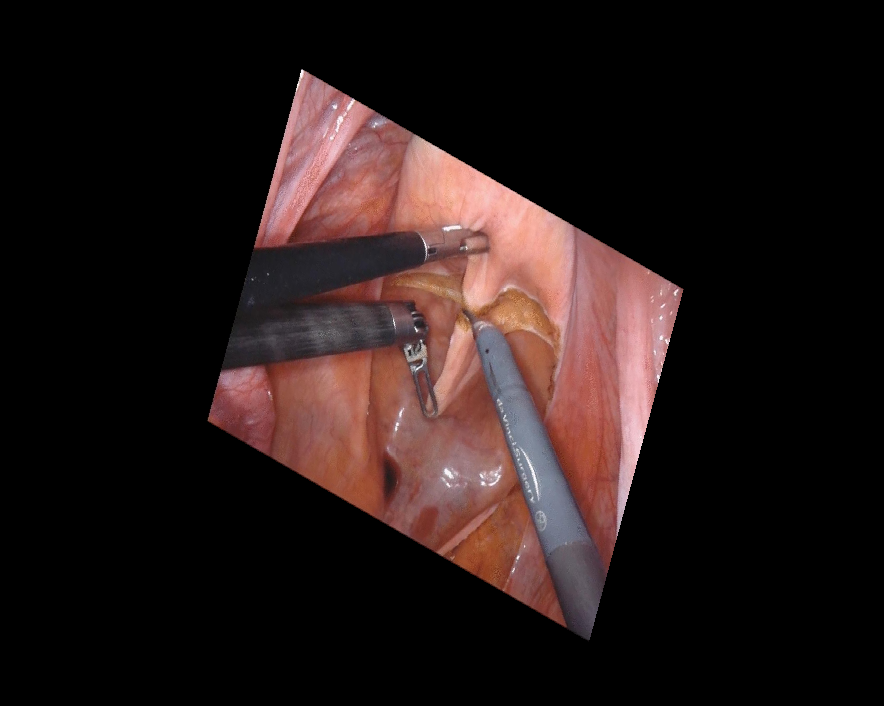

In [ ]:
img_dir = 'inpaint_demo.jpg'
original = Image.fromarray(image_source)
TF.affine(original, 30, [3,2], 0.5, -15)

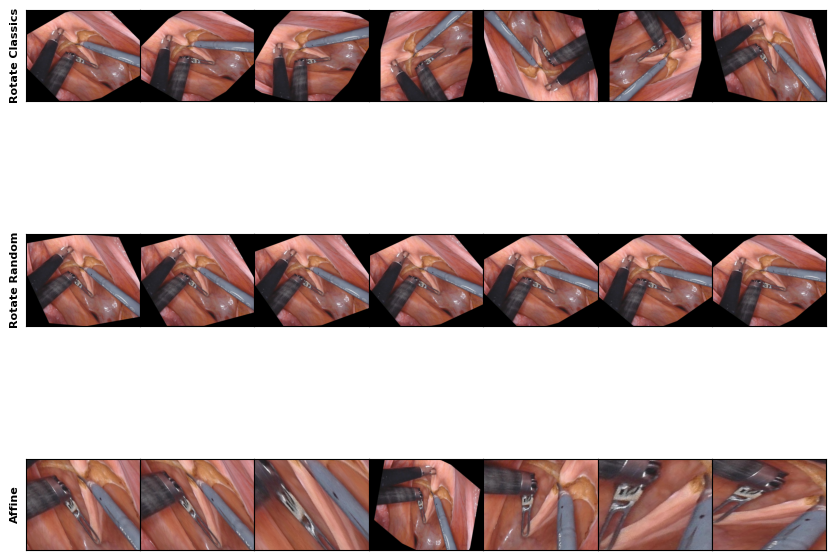

In [ ]:
import os
img_dir = 'inpaint_demo.jpg'
original = Image.fromarray(image_source)
geometry_type = ['Rotate Classics', 'Rotate Random', 'Affine']
seq_all = [0, 1, 2, 3, 4, 5, 6]
sizes = [50, 150, 250, 350, 450, 550, 700]
perturbation_geometry = ['rotate_pic', 'rotate_pic2', 'affine']
fig_per_row = len(seq_all)
if os.path.isdir('perturbed_imgs'):
    print(f"{'perturbed_imgs'} exists.")
else:
  os.mkdir('perturbed_imgs')
fig, ax = plt.subplots(len(perturbation_geometry), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
for p_idx, per in enumerate(perturbation_geometry):
    class_method = getattr(geometric_class, per)
    seq = class_method(original)
    for idx, seq_idx in enumerate(seq_all):
      ax[p_idx, idx].imshow(seq[seq_idx])
      seq[seq_idx].save('perturbed_imgs/perturbed{}.png'.format(seq_idx))
      #seq[seq_idx].save('rotated_imgs/rotated{}.png'.format(seq_idx))
      #if p_idx == 0:
        #ax[p_idx, idx].set_title('Size: ' + '{}'.format(sizes[idx]), fontsize=f_size)
      if idx == 0:
        ax[p_idx, idx].set_ylabel(geometry_type[p_idx], fontsize=f_size, fontweight="bold")

      ax[p_idx, idx].xaxis.set_major_locator(plt.NullLocator())
      ax[p_idx, idx].yaxis.set_major_locator(plt.NullLocator())
plt.savefig('Crop_Effects.pdf',dpi=100)

Adversarial Attacks (for M)

Transposing the images so that they have the same shape that the model takes in

In [ ]:
print(seq[0].size, np.array(seq[0]).shape, image.shape)
img_perturb_np = np.array(seq[0]).transpose(2, 0, 1)
img_perturb_tr  = torch.tensor(img_perturb_np)
img_perturb_np.shape, img_perturb_tr.shape

(884, 706) (706, 884, 3) torch.Size([3, 800, 1001])


((3, 706, 884), torch.Size([3, 706, 884]))

Loading the Affine transformed images into variables to pass into model

In [ ]:
image_source, image = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed1.png')
image_source2, image2 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed2.png')
image_source3, image3 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed3.png')
image_source4, image4 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed4.png')
image_source5, image5 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed5.png')
image_source6, image6 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed6.png')

Loadding the rotate classics transformed images into variables to pass into model

In [ ]:
image_src_cropped, image_crop = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop0.png')
image_src_cropped2, image_crop2 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop1.png')
image_src_cropped3, image_crop3 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop2.png')
image_src_cropped4, image_crop4 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop3.png')
image_src_cropped5, image_crop5 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop4.png')
image_src_cropped6, image_crop6 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop5.png')
image_src_cropped6, image_crop6 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop6.png')

Grounding DINO to Detect Object with Prompt

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
logits: tensor([0.4753, 0.3735, 0.3169, 0.3309])


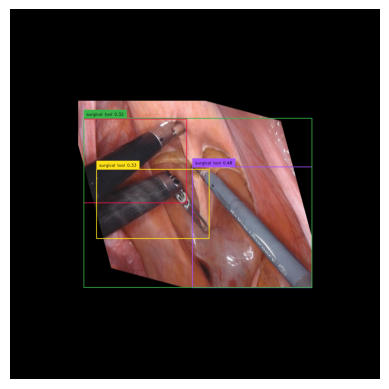

In [ ]:
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
import matplotlib.pyplot as plt

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)


def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_src_cropped6, boxes=boxes, logits=logits, phrases=phrases) # Update image_source variable
  print('logits:', logits)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

annotated_frame, detected_boxes = detect(image=image_crop6, text_prompt="surgical tool", model=groundingdino_model) # Update image variable
predicted_img = Image.fromarray(annotated_frame)
plt.imshow(predicted_img)
plt.axis('OFF');

MSE error:

In [ ]:
detected_boxes

tensor([[0.7396, 0.6694, 0.5175, 0.6528],
        [0.3197, 0.5512, 0.4806, 0.3699],
        [0.2449, 0.3240, 0.4404, 0.4453]])

SAM for Segmentation from Detected Bounding Box:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'

--2023-11-08 15:47:27--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   130MB/s    in 11s     

2023-11-08 15:47:39 (213 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

  Preparing metadata (setup.py) ... done


Restart Runtime, please! (if segment_anything not found)

In [ ]:
%cd /content/Grounded-Segment-Anything
from segment_anything import build_sam, SamPredictor
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

/content/Grounded-Segment-Anything


TypeError: ignored

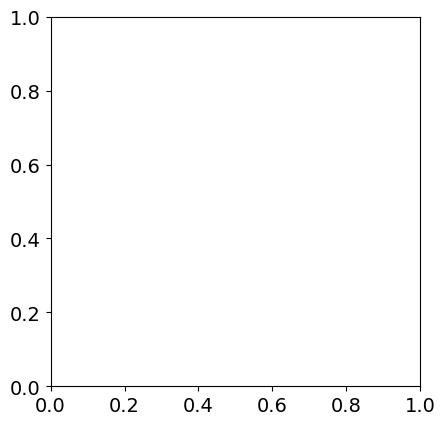

In [ ]:
import numpy as np

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
# annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
# instance_seg1 = Image.fromarray(annotated_frame_with_mask)
binary_seg = segmented_frame_masks.squeeze()#.any(axis=0)
#binary_seg[binary_seg==True] = 1
plt.imshow(binary_seg.int());
plt.axis('OFF');

Intersection over Union (IoU)

In [ ]:
segmented_frame_masks.sum(), segmented_frame_masks.shape

In [ ]:
segmented_frame_masks.sum()